# How to create Figure 3


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from odefilters import odesolver
from odefilters import linearised_odesolver as linsolver
from odefilters import linearised_ode as linode
from odefilters import statespace
from odefilters import inverseproblem as ip

At first we create the data, set the model parameters and the method parameters.

In [2]:
def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, 1, 0)
    evalpts = 2* np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = np.array([means[evalidx] + np.sqrt(ivpvar)*np.random.randn()
                     for evalidx in evalidcs])
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata


In [3]:
# Set Model Parameters
initial_value = 0.25
initial_time, end_time = 0., 2.
ivpvar = 1e-6
thetatrue = np.array([2.5, 2.5])
ivp = linode.LogisticODE(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/1000
h = (end_time - initial_time)/200
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=1))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)


Now we compute the gradients, the Hessians and the contour lines on a grid. **This might tike a few minutes**.

In [5]:
# Draw a grid and compute gradient approximations
delta = 0.02
xpts = np.arange(2.2, 2.8+delta, delta)
ypts = np.arange(2.2, 2.8+delta, delta)
X1, Y1 = np.meshgrid(xpts, ypts)
lklgrid = np.zeros(X1.shape)
# gradgrid1 = np.zeros(X.shape)
# gradgrid2 = np.zeros(X.shape)
# hessgrid1 = np.zeros(X.shape)
# hessgrid2 = np.zeros(X.shape)
for i in range(len(X1)):
    for j in range(len(Y1)):
        this_theta = np.array([X1[i, j], Y1[i, j]])
        lklgrid[i, j] = np.exp(-iplklhd.potenteval(this_theta))

        delta = 0.1
xpts = np.arange(2.2, 2.8+delta, delta)
ypts = np.arange(2.2, 2.8+delta, delta)
X, Y = np.meshgrid(xpts, ypts)
gradgrid1 = np.zeros(X.shape)
gradgrid2 = np.zeros(X.shape)
hessgrid1 = np.zeros(X.shape)
hessgrid2 = np.zeros(X.shape)
for i in range(len(X)):
    for j in range(len(X.T)):
        this_theta = np.array([X[i, j], Y[i, j]])
        np.exp(-iplklhd.potenteval(this_theta))
        gradvl = iplklhd.gradeval(this_theta)
        gradgrid1[i, j] = gradvl[0]
        gradgrid2[i, j] = gradvl[1]

        hessvl = iplklhd.hesseval(this_theta)
        precon_grad = np.linalg.solve(hessvl, gradvl)
        hessgrid1[i, j] = precon_grad[0]
        hessgrid2[i, j] = precon_grad[1]

delta = 0.0005
xpts = np.arange(2.48, 2.52+delta, delta)
ypts = np.arange(2.48, 2.52+delta, delta)
X2, Y2 = np.meshgrid(xpts, ypts)
lklgrid2 = np.zeros(X2.shape)
for i in range(len(X2)):
    for j in range(len(Y2)):
        this_theta = np.array([X2[i, j], Y2[i, j]])
        lklgrid2[i, j] = np.exp(-iplklhd.potenteval(this_theta))

        
delta = 0.00625
xpts = np.arange(2.48, 2.52, delta)
ypts = np.arange(2.48, 2.52, delta)
X3, Y3 = np.meshgrid(xpts, ypts)
gradgrid1_ = np.zeros(X3.shape)
gradgrid2_ = np.zeros(X3.shape)
hessgrid1_ = np.zeros(X3.shape)
hessgrid2_ = np.zeros(X3.shape)
for i in range(len(X3)):
    for j in range(len(X3.T)):
        this_theta = np.array([X3[i, j], Y3[i, j]])
        np.exp(-iplklhd.potenteval(this_theta))
        gradvl = iplklhd.gradeval(this_theta)
        gradgrid1_[i, j] = gradvl[0]
        gradgrid2_[i, j] = gradvl[1]

        hessvl = iplklhd.hesseval(this_theta)
        precon_grad = np.linalg.solve(hessvl, gradvl)
        hessgrid1_[i, j] = precon_grad[0]
        hessgrid2_[i, j] = precon_grad[1]



Finally, we can plot the results

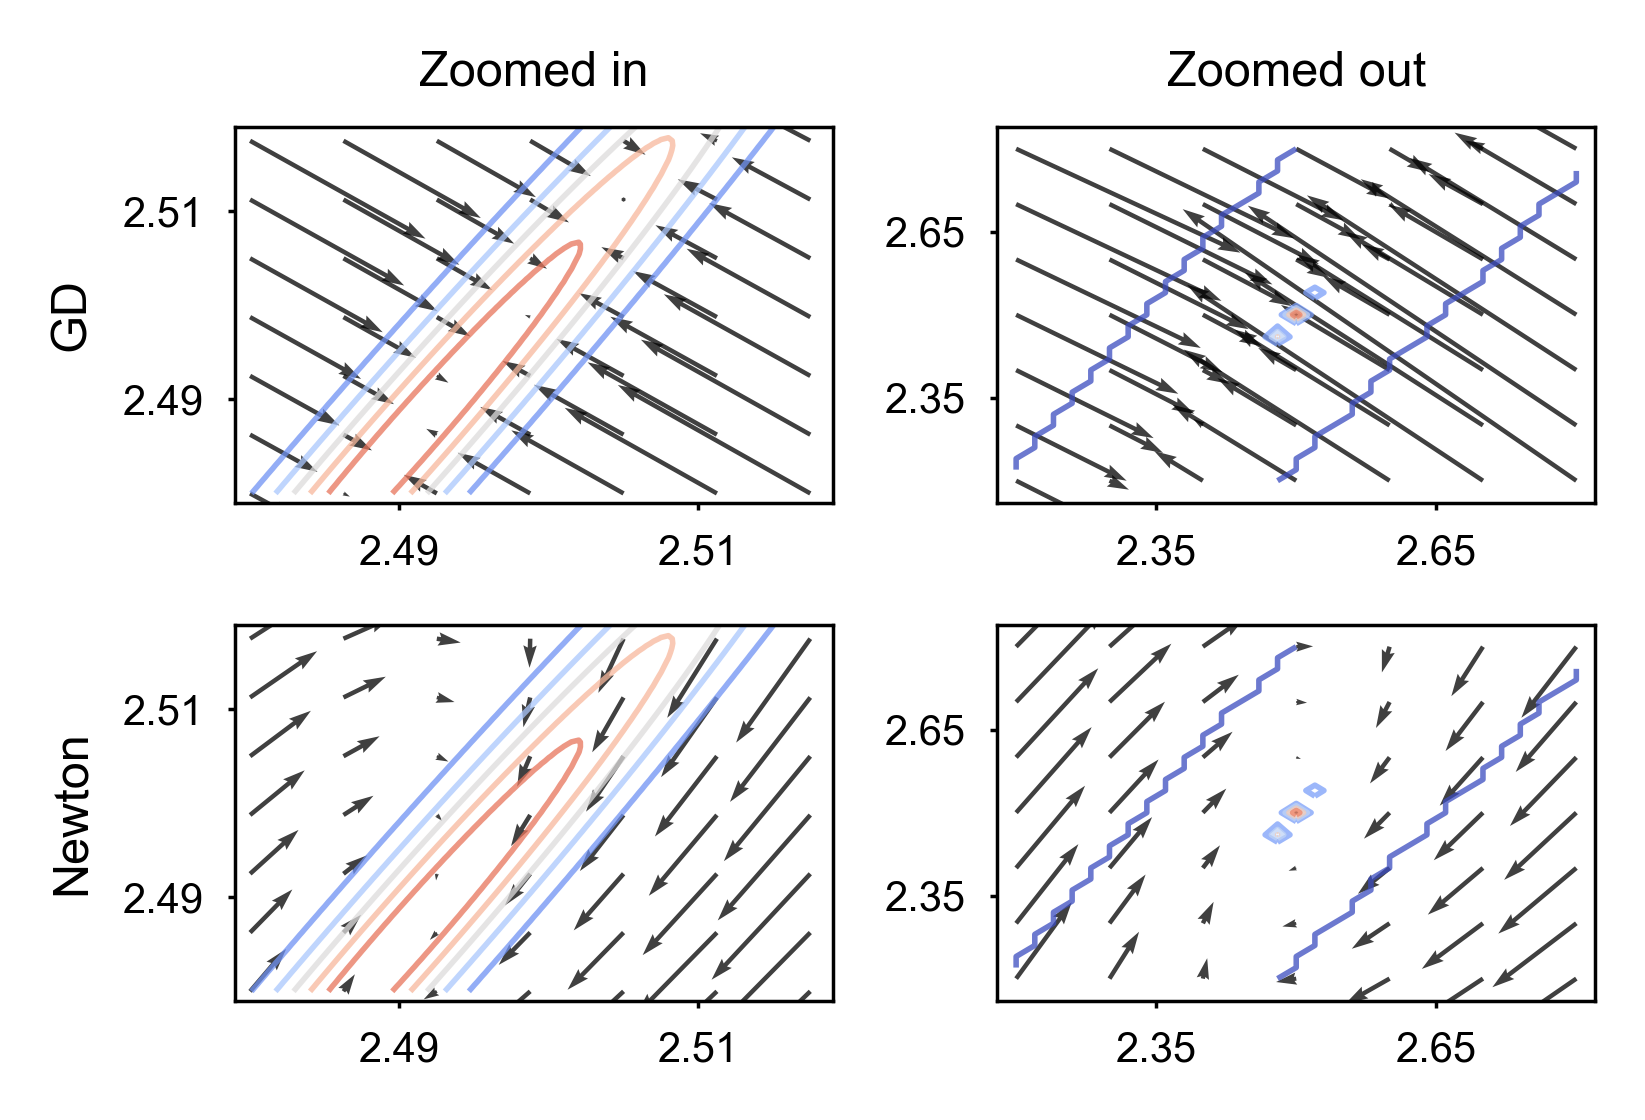

In [6]:
# Visualise results

colormap = 'coolwarm'
_alpha = 0.15

plt.style.use("./icmlstyle.mplstyle")
# plt.rc('font', size=25)                # controls default text sizes
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(3.3, 2.25))

colormap = 'coolwarm'
_alpha = 0.75

hessscale = -0.225
gradscale = -1.25e-5

hessscale_ = -3.6
gradscale_ = -1.25e-4

ax[0][0].set_title("Zoomed in")
ax[0][0].set_ylabel("GD")
ax[0][0].contour(X2, Y2, lklgrid2, levels=6, cmap=colormap, alpha=_alpha)
ax[0][0].quiver(X3, Y3, gradscale_*gradgrid1_, gradscale_*gradgrid2_, scale=1, width=0.0075, alpha=0.75, color='black')
ax[0][0].grid(False)
ax[0][0].set_xticks([2.49, 2.51])
ax[0][0].set_yticks([2.49, 2.51])
ax[0][0].set_xlim((2.48-0.001, 2.52-0.001))
ax[0][0].set_ylim((2.48-0.001, 2.52-0.001))



ax[0][1].set_title("Zoomed out")
ax[0][1].contour(X1, Y1, lklgrid, levels=6, cmap=colormap, alpha=_alpha)
ax[0][1].quiver(X, Y, gradscale*gradgrid1, gradscale*gradgrid2, scale=1, width=0.0075, alpha=0.75, color='black')
ax[0][1].grid(False)
ax[0][1].set_xticks([2.35, 2.65])
ax[0][1].set_yticks([2.35, 2.65])
ax[0][1].set_xlim((2.2-0.02, 2.8+0.02))
ax[0][1].set_ylim((2.2-0.04, 2.8+0.04))

ax[1][0].set_ylabel("Newton")
ax[1][0].contour(X2, Y2, lklgrid2, levels=6, cmap=colormap, alpha=_alpha)
ax[1][0].quiver(X3, Y3, hessscale_*hessgrid1_, hessscale_*hessgrid2_, scale=1, width=0.0075, alpha=0.75, color='black')
ax[1][0].grid(False)
ax[1][0].set_xticks([2.49, 2.51])
ax[1][0].set_yticks([2.49, 2.51])
ax[1][0].set_xlim((2.48-0.001, 2.52-0.001))
ax[1][0].set_ylim((2.48-0.001, 2.52-0.001))


ax[1][1].contour(X1, Y1, lklgrid, levels=6, cmap=colormap, alpha=_alpha)
ax[1][1].quiver(X, Y, hessscale*hessgrid1, hessscale*hessgrid2, scale=1, width=0.0075, alpha=0.75, color='black')
ax[1][1].grid(False)
ax[1][1].set_xticks([2.35, 2.65])
ax[1][1].set_yticks([2.35, 2.65])
ax[1][1].set_xlim((2.2-0.02, 2.8+0.02))
ax[1][1].set_ylim((2.2-0.04, 2.8+0.04))



for ax_ in ax.flatten():
    ax_.spines["top"].set_visible(True)    
    ax_.spines["right"].set_visible(True)    
    ax_.spines["bottom"].set_visible(True)    
    ax_.spines["left"].set_visible(True)    


plt.tight_layout()
plt.savefig("./figures/figure3_arrows")
plt.show()




